In [1]:
import os
import sys
sys.path.append('/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages')
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import shutil as sh
import math
import time
import seaborn as sns
from tqdm import tqdm

# Φ1,Φ2の2自由度を導入

In [2]:
class FF_phi1phi2():
    
    #ヘリンボーンパラメータとYorZ入れる。glide=a→Z, glide=b→Y
    def __init__(self,R1,R2,heri,R3t,R3p,glide):
        self.R1=R1;self.R2=R2;self.heri=heri;self.glide=glide
        self.R3t=R3t;self.R3p=R3p
        
        self.path='/Users/jigenji/Working/interaction/mono-C9-BTBT/FF/'
        
        self.phi_list=np.linspace(-180.0,180.0,73)#回転角
        
        A_rad=np.radians(heri/2)
        self.a_=2*(R1*np.cos(A_rad)-R2*np.sin(A_rad))
        self.b_=2*(R2*np.cos(A_rad)+R1*np.sin(A_rad))

        self.glide = glide
        
        #侵入の閾値
        self.inv=1.0

    #theta_in 
    def Rod(self,n,theta_in):
        nx,ny,nz=n
        theta_t=np.radians(theta_in)
        Rod=np.array([[np.cos(theta_t)+(nx**2)*(1-np.cos(theta_t)),nx*ny*(1-np.cos(theta_t))-nz*np.sin(theta_t),nx*nz*(1-np.cos(theta_t))+ny*np.sin(theta_t)],
                    [nx*ny*(1-np.cos(theta_t))+nz*np.sin(theta_t),np.cos(theta_t)+(ny**2)*(1-np.cos(theta_t)),ny*nz*(1-np.cos(theta_t))-nx*np.sin(theta_t)],
                    [nx*nz*(1-np.cos(theta_t))-ny*np.sin(theta_t),ny*nz*(1-np.cos(theta_t))+nx*np.sin(theta_t),np.cos(theta_t)+(nz**2)*(1-np.cos(theta_t))]])
        return Rod


    #分子1分子2を作成(回転させただけ・平行移動なし)
    def convertor(self,atom_list,A,phi1,phi2):#A=heri/2
        atom_list_i=[];atom_list_pa=[];atom_list_pb=[]
        atom_list_t1=[];atom_list_t2=[];atom_list_t3=[];atom_list_t4=[]
        
        #alkylの基準
        C0=np.array([atom_list[16][1],atom_list[16][2],atom_list[16][3]])
        C1=np.array([atom_list[23][1],atom_list[23][2],atom_list[23][3]])
        
        #phi1に関するalkylの軸
        n1=C1-C0
        n1/=np.linalg.norm(n1)
        
        #映進面によって回転角変える
        glide=180.0 if self.glide=='a' else 0.0
        
        #alkyl回転・分子1作成
        for ind,(atom,x,y,z,R,q,sig,eps) in enumerate(atom_list):
            x1=x;y1=y;z1=z
            x2=x;y2=y;z2=z
            #alkylだけΦ回転　phi1=-phi2のとき映進
            if ind>=23:#alkyl?
                x1,y1,z1=np.matmul(self.Rod(n1,phi1),(np.array([x,y,z])-C0).T)
                x1,y1,z1=C0+np.array([x1,y1,z1])
                x2,y2,z2=np.matmul(self.Rod(n1,phi2),(np.array([x,y,z])-C0).T)
                x2,y2,z2=C0+np.array([x2,y2,z2])
            
            #heri/2回転 i,t作成
            x1,y1,z1=np.matmul(self.Rod(np.array([0,0,1]),A),np.array([x1,y1,z1]).T)
            x2,y2,z2=np.matmul(self.Rod(np.array([0,0,1]),-A+glide),np.array([x2,y2,z2]).T)
            
            #基準分子
            atom_list_i.append([atom,x1,y1,z1,R,q,sig,eps])
            
#             #a軸方向のp配置
#             atom_list_pa.append([atom,
#                                  self.a_+x1,
#                                  y1,
#                                  2*self.R3t-self.R3p+z1,
#                                  R,q,sig,eps])
            
            #b軸方向のp配置
            atom_list_pb.append([atom,
                                 x1,
                                 self.b_+y1,
                                 self.R3p+z1,
                                 R,q,sig,eps])
            
            #[a/2,b/2,R3t]平行移動
            atom_list_t1.append([atom,
                                 self.a_/2+x2,
                                 self.b_/2+y2,
                                 self.R3t+z2,
                                 R,q,sig,eps]) 
            
            #[a/2,-b/2,R3t-R3p]平行移動
            atom_list_t2.append([atom,
                                 self.a_/2+x2,
                                 -self.b_/2+y2,
                                 self.R3t-self.R3p+z2,
                                 R,q,sig,eps])
            
            #[-a/2,-b/2,-R3t]平行移動
            atom_list_t3.append([atom,
                                 -self.a_/2+x2,
                                 -self.b_/2+y2,
                                 -self.R3t+z2,
                                 R,q,sig,eps])
            
            #[-a/2,b/2,-R3t+R3p]平行移動
            atom_list_t4.append([atom,
                                 -self.a_/2+x2,
                                 self.b_/2+y2,
                                 -self.R3t+self.R3p+z2,
                                 R,q,sig,eps])
                            
        atom_list_others=[atom_list_pb,atom_list_t1,atom_list_t2,atom_list_t3,atom_list_t4]#atom_list_pa,
        return atom_list_i,atom_list_others

    #phiの範囲を出力
    def calc_phi(self):
        type_='Y' if self.glide=='b' else 'Z'
        print(os.path.join(self.path,'glide={}/FF_phi1phi2_{}-type_R3t={}_R3p={}.csv'.format(self.glide,type_,self.R3t,self.R3p)))
        if os.path.exists(os.path.join(self.path,'glide={}/FF_phi1phi2_{}-type_R3t={}_R3p={}.csv'.format(self.glide,type_,self.R3t,self.R3p))):
            return
        df=pd.DataFrame(columns=['R1','R2','heri','R3t','R3p','phi1','phi2','FF'])
        df_mono=pd.read_csv(self.path+'monomer.csv') ###x,y,z,rad
        monomer=df_mono[['atom','X','Y','Z','R','q','sig','eps']].values
        e=1.602176634*(10**(-19))
        
        
        start=time.time()
        for phi1 in tqdm(self.phi_list):
            for phi2 in self.phi_list:
                BTBT_1,BTBT_others=self.convertor(monomer,self.heri/2,phi1,phi2)
                
                #FF
                FF_list=[]

                #アルキルの各原子同士が衝突したらbreak
#                 st= time.time()
                for ind1,(atom1,x1,y1,z1,R1,q1,sig1,eps1) in enumerate(BTBT_1[23:]):
                    for ind2,BTBT_2 in enumerate(BTBT_others):
                        FF=0
                        for ind3,(atom2,x2,y2,z2,R2,q2,sig2,eps2) in enumerate(BTBT_2[23:]):
                            
                            r=np.linalg.norm([x1-x2,y1-y2,z1-z2])
                            q=q1*q2*(e**2)
                            sig=np.sqrt(sig1*sig2)
                            eps=np.sqrt(eps1*eps2)
                            FF+=q/r+4*eps*((sig/r)**12-(sig/r)**6)
                        FF_list.append(FF)
#                 print(time.time()-st)
                #平行配置だけ2倍
                FF_sum=sum(FF_list)+FF_list[0]
                
                
                data=pd.Series([self.R1,self.R2,self.heri,self.R3t,self.R3p,phi1,phi2,FF_sum],index=['R1','R2','heri','R3t','R3p','phi1','phi2','FF'])
                df=df.append(data,ignore_index=True)
            
#             if ind%30==29:
#                 print("{}% finished".format(int(100*ind/len(self.phi_list))))
            
        
        df.to_csv(os.path.join(self.path,'glide={}/FF_phi1phi2_{}-type_R3t={}_R3p={}.csv'.format(self.glide,type_,self.R3t,self.R3p)),index=False)

    # def calc_FF_min(self):
    #     type_ = 'Z' if glide_mode=='a' else 'Y'
    #     FF_path = os.path.join(self.path,'glide={}/FF_phi1phi2_{}-type_R3t={}_R3p={}.csv'.format(self.glide,type_,self.R3t,self.R3p))
    #     df_FF = pd.read_csv(FF_path)
    #     b= df_FF[['R1','R2','heri','R3t','R3p','phi1','phi2','FF']].values
    #     for phi1 in tqdm(self.phi_list):
    #         for phi2 in self.phi_list:


# test (step1 Ymin)

In [1]:
for R3t in np.linspace(-2.0,2.0,41):
    for R3p in np.linspace(-2.0,2.0,41):
        R3t=np.round(R3t,1)
        R3p=np.round(R3p,1)
        FF=FF_phi1phi2(R1=5.0,R2=1.0,heri=58.0,R3t=R3t,R3p=R3p,glide='b')
        FF.calc_phi()
# FF=FF_phi1phi2(R1=5.0,R2=0.7,heri=58.0,R3t=0.0,R3p=0.0,glide='a')

In [126]:
#不足分追加。
os.remove('/Users/jigenji/Working/interaction/mono-C9-BTBT/FF/glide=b/FF_phi1phi2_Y-type_R3t=1.5_R3p=-0.9.csv')
R3t=1.5
R3p=-0.9
FF=FF_phi1phi2(R1=5.0,R2=1.0,heri=58.0,R3t=R3t,R3p=R3p,glide='b')
FF.calc_phi()

100%|██████████| 73/73 [05:59<00:00,  4.92s/it]


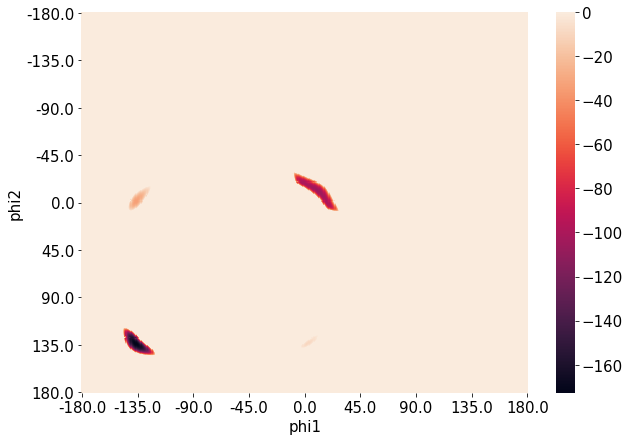

In [12]:
df_FF=pd.read_csv(FF.path+'FF_phi1phi2_Y-type_R3t=0.0_R3p=0.0.csv')

plt.rcParams['figure.figsize']=10,7
plt.rcParams['font.size']=15
import seaborn as sns
sns.heatmap(df_FF.pivot("phi2", "phi1", "FF"),vmax=0.0,xticklabels=45,yticklabels=45)

MovieWriter imagemagick unavailable; using Pillow instead.


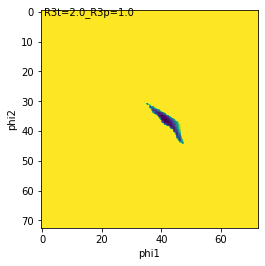

In [57]:
from matplotlib.animation import ArtistAnimation

R3p=1.0
glide_mode='b'

# fig = plt.figure()
fig, ax = plt.subplots(figsize=(4, 4))
ims = []
YorZ = 'Y' if glide_mode=='b' else 'Z'
for R3t in np.linspace(-2.0,2.0,41):
    R3t=np.round(R3t,1)
    # R3p=np.round(R3p,1)
    df_FF=pd.read_csv(FF.path+f'glide={glide_mode}/FF_phi1phi2_{YorZ}-type_R3t={R3t}_R3p={R3p}.csv')
    hmap = ax.imshow(df_FF.pivot("phi2", "phi1", "FF"),vmax=0.0)#,label=f'R3t={R3t}_R3p={R3p}')
#     plt.title(f'R3t={R3t}_R3p={R3p}')
    ax.set_xlabel('phi1')
    ax.set_ylabel('phi2')
    title = ax.text(0.5, 1.01,f'R3t={R3t}_R3p={R3p}')
#     hmap = sns.heatmap(df_FF.pivot("phi2", "phi1", "FF"),vmax=0.0,xticklabels=45,yticklabels=45)
    ims.append([hmap,title])
#     plt.show()

ani = ArtistAnimation(fig, ims)
ani.save('anim_R3p={}_glide={}.gif'.format(R3p,glide_mode), writer="imagemagick")
# ani.save('anim.mp4', writer="ffmpeg")
# plt.show()

# ピーク検出

In [127]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import minimum_filter

# ピーク検出関数
def detect_peaks(image, filter_size=3):
    local_min = minimum_filter(image, footprint=np.ones((filter_size, filter_size)), mode='constant')
    detected_peaks = np.ma.array(image, mask=~(image == local_min))

    # # 小さいピーク値を排除（最大ピーク値のorder倍のピークは排除）
    # temp = np.ma.array(detected_peaks, mask=~(detected_peaks >= detected_peaks.max() * order))
    # peaks_index = np.where((temp.mask != True))

    # 正のピーク値を排除（最大ピーク値のorder倍のピークは排除）
    temp = np.ma.array(detected_peaks, mask=~(detected_peaks < 0))
    peaks_index = np.where(temp.mask!=True)
    
    return peaks_index

def extract_localmin(R1,R2,heri,R3t,R3p,glide):
    FF=FF_phi1phi2(R1=R1,R2=R2,heri=heri,R3t=R3t,R3p=R3p,glide=glide)

    type_ = 'Z' if FF.glide=='a' else 'Y'
    FF_path = os.path.join(FF.path,'glide={}/FF_phi1phi2_{}-type_R3t={}_R3p={}.csv'.format(FF.glide,type_,FF.R3t,FF.R3p))
    df_FF = pd.read_csv(FF_path)

    Map_val = np.reshape(df_FF['FF'].values, (df_FF['phi1'].nunique(),df_FF['phi2'].nunique())).T

    phi_interval = 360/(Map_val.shape[0]-1)
    maxid1 = detect_peaks(Map_val)

    phi1phi2FF_localmin_list = []
    for (id2, id1) in np.array(maxid1).T:
        phi1phi2FF_localmin = [R1,R2,heri,R3t,R3p,glide,id1*phi_interval-180, id2*phi_interval-180 ,Map_val[id2][id1]]
        phi1phi2FF_localmin_list.append(phi1phi2FF_localmin)

    df_phi1phi2FF_localmin = pd.DataFrame(phi1phi2FF_localmin_list,columns=['R1','R2','heri','R3t','R3p','glide','phi1','phi2','FF'])
    return df_phi1phi2FF_localmin #[phi1,phi2,FF]のdf


In [134]:
df_localmin_list = []

#Y type
for R3t in tqdm(np.linspace(-2.0,2.0,41)):
    for R3p in np.linspace(-2.0,2.0,41):
        R3t=np.round(R3t,1)
        R3p=np.round(R3p,1)
        df_localmin_current = extract_localmin(R1=5.0,R2=1.0,heri=58.0,R3t=R3t,R3p=R3p,glide='b')
        df_localmin_list.append(df_localmin_current)

#Z type
for R3t in tqdm(np.linspace(-2.0,2.0,41)):
    for R3p in np.linspace(-2.0,2.0,41):
        R3t=np.round(R3t,1)
        R3p=np.round(R3p,1)
        df_localmin_current = extract_localmin(R1=5.0,R2=0.7,heri=58.0,R3t=R3t,R3p=R3p,glide='a')
        df_localmin_list.append(df_localmin_current)

df_localmin=pd.concat(df_localmin_list, ignore_index=True)
df_localmin.to_csv('./FF_localmin.csv',index=False)

100%|██████████| 41/41 [00:32<00:00,  1.25it/s]
